In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re

pd.set_option('max_column', 100)

In [2]:
def get_max_pages(domain, path, tag):
    
    url = f'{domain}/{path}'
    r = requests.get(url)
    soup = BeautifulSoup(r.text)
    
    ### get the number of pages of active players

    return  int(soup.findAll(tag, text='Last')[0].get('data-val'))

In [9]:
links = []
domain = 'https://www.capfriendly.com'
path = 'browse/active'
href = 'browse/active?&pg='
tag = 'a'

for page in range(1, 
                  get_max_pages(domain, path, 'a') + 1):
    url = f'{domain}/{href}{page}'
    r = requests.get(url)
    soup = BeautifulSoup(r.text)
    
    for link in soup.findAll('a', attrs={'href': re.compile("players")}):
        links.append(domain + link.get('href'))

### Get contract metadata

In [3]:
def get_current_contract_meta(data, url, contract_id):

    # Get metadata div
    meta = data.find('div', 
#                      attrs={'class' : 'contract_data rel cntrct'}
                    )
    # start with empty dictionary
    row = {}
    # player url is key
    row['player_url'] = url
    row['contract_id'] = contract_id
    # get header for player contract type
    header = meta.find_all('h6')
    for h in header:
        row['contract_type'] = h.text
    # loop over divs to get attributes of contract
    for m in meta:
        d = m.find_all('div')
        for t in d:
            if ':' in t.text:
                if "SOURCE" in t.text:
                    try:
                        row['source'] = t.find('a').get('href')
                    except:
                        # no source
                        row['source'] = None
                else:
                    row[t.text.split(':', maxsplit=1)[0].lower()] =  t.text.split(':', maxsplit=1)[1]           
    # contruct data frame and set player url as index
    player_meta = pd.DataFrame([row]).set_index('player_url')
    
    return player_meta

In [264]:
get_current_contract_meta(data, url, contract_id)

,contract_id,contract_type,length,expiry status,signing team,value,c.h.%,signing date,source
player_url,,,,,,,,,
https://www.capfriendly.com/players/connor-mcdavid,1,STANDARD CONTRACT (EXTENSION),8 YEARS,UFA,Edmonton Oilers,"$100,000,000",16.67,"July 5, 2017",https://www.twitter.com/@CapFriendly/status/88...


### Get contract table

In [4]:
def get_current_contract_table(data, url, contract_id):
    # Get table div
    table = data.find('table')
    # set empty list for data
    l = []
    # get all rows for table
    table_rows = table.find_all('tr')
    for tr in table_rows:
        td = tr.find_all('td')
        row = [tr.text for tr in td]
        l.append(row)
    # contruct data frame for contract life
    player_contract = pd.DataFrame(l[1:], columns=[col.lower() for col in l[0]])
    player_contract['player_url'] = url
    player_contract['contract_id'] = contract_id
    
    return player_contract

In [5]:
def get_current_contract_data(data, contract_id, url):
    
    print(f'''Contract ID: {contract_id}''')
    
    player_contract = get_current_contract_table(data, url, contract_id)
    # get player contract metadata from response
    player_meta = get_current_contract_meta(data, url, contract_id)
    # merge dataframes
    current_contract = player_meta.merge(player_contract, on = ['player_url', 'contract_id'])
    
    return current_contract

In [50]:
url = 'https://www.capfriendly.com/players/jt-miller'
r = requests.get(url)
soup = BeautifulSoup(r.text)



In [6]:
def get_player_info(soup):
    
    player_info = {}
    player = soup.find_all('h1', {'class': 'c'})[0]
    
    try:
        player_name, number = player.text.split(' #', maxsplit=1)
        
    except:
        player_name = player.text
        number = None
        
    player_name = player_name.title()

    player_info['player_name'] = player_name
    player_info['player_number'] = number

    info = soup.find_all('div', {'class':'indx_b'})

    for i in info:
        d = i.find_all('div')
        for t in d:
            if ':' in t.text:
                player_info[t.text.split(':', maxsplit=1)[0].lower()] = t.text.split(':', maxsplit=1)[1].lstrip().rstrip()
                
    return player_info

### Run for all active players

In [7]:
contract_id = 1

def get_contract_data(url):
    import random
    import time 
    
    global contract_id

    try:
        print(f'''--- Getting Capfriendly data for: {url} ---''')
        ### give it some random wait time so it IP doesn't get blocked
        time.sleep(random.uniform(1, 2.5))
        
        r = requests.get(url)
        soup = BeautifulSoup(r.text)
        # get player information
        player_info = get_player_info(soup)
        # get contract data
        data = soup.find_all('div',{'class':'table_c contract_cont',})
        # list for all contracts
        player_data = []
        # loop over contracts
        for d in data:
            player_data.append(get_current_contract_data(d, contract_id, url))
            contract_id += 1

        contracts = pd.concat(player_data)

        # add player info to data frames
        for k, v in player_info.items():
            contracts[k] = v

        return contracts
    
    except Exception as e:
        
        print(e)

In [86]:
url = 'https://www.capfriendly.com/players/connor-mcdavid'
url = 'https://www.capfriendly.com/players/artemi-panarin'
print(f'''--- Getting Capfriendly data for: {url} ---''')
r = requests.get(url)
soup = BeautifulSoup(r.text)
# get player information
player_info = get_player_info(soup)
# get contract data
data = soup.find_all('div',{'class':'table_c contract_cont',})
# list for all contracts
player_data = []

--- Getting Capfriendly data for: https://www.capfriendly.com/players/artemi-panarin ---


In [91]:
contract_id = 1
for d in data:
    player_data.append(get_current_contract_data(d, contract_id, url))
    contract_id += 1

Contract ID: 1
Contract ID: 2
Contract ID: 3


In [10]:
contract_id = 1

player_contracts = pd.concat([get_contract_data(url) for url in links], sort=False)

# # data pre-processing step
contract_length = player_contracts.groupby('contract_id').apply(lambda x : len(x) - 1) ### capfriendly pulls data for totals
contract_length.name = 'contract_length'
player_contracts = player_contracts.merge(contract_length, left_on = 'contract_id', right_index=True)

# cap-hit percentage
player_contracts['percent_of_cap'] = player_contracts['c.h.% '].astype(float) / 100
# turn contract value to floats
player_contracts['value'] = player_contracts.value.replace('[\$,]', '', regex=True).astype(float)
player_contracts['cap hit'] = player_contracts.value.replace('[\$,]', '', regex=True).astype(float)
player_contracts['aav'] = player_contracts.value.replace('[\$,]', '', regex=True).astype(float)
player_contracts['p. bonuses'] = player_contracts.value.replace('[\$,]', '', regex=True).astype(float)
player_contracts['s. bonuses'] = player_contracts.value.replace('[\$,]', '', regex=True).astype(float)
player_contracts['base salary'] = player_contracts.value.replace('[\$,]', '', regex=True).astype(float)
player_contracts['total salary'] = player_contracts.value.replace('[\$,]', '', regex=True).astype(float)
player_contracts['minors sal'] = player_contracts.value.replace('[\$,]', '', regex=True).astype(float)

--- Getting Capfriendly data for: https://www.capfriendly.com/covid-roster-freeze-players ---
list index out of range
--- Getting Capfriendly data for: https://www.capfriendly.com/covid-roster-freeze-players ---
list index out of range
--- Getting Capfriendly data for: https://www.capfriendly.com/players/connor-mcdavid ---
Contract ID: 1
Contract ID: 2
--- Getting Capfriendly data for: https://www.capfriendly.com/players/artemi-panarin ---
Contract ID: 3
Contract ID: 4
Contract ID: 5
--- Getting Capfriendly data for: https://www.capfriendly.com/players/auston-matthews ---
Contract ID: 6
Contract ID: 7
--- Getting Capfriendly data for: https://www.capfriendly.com/players/erik-karlsson ---
Contract ID: 8
Contract ID: 9
Contract ID: 10
--- Getting Capfriendly data for: https://www.capfriendly.com/players/john-tavares ---
Contract ID: 11
Contract ID: 12
Contract ID: 13
--- Getting Capfriendly data for: https://www.capfriendly.com/players/drew-doughty ---
Contract ID: 14
Contract ID: 15
Con

Contract ID: 170
Contract ID: 171
Contract ID: 172
--- Getting Capfriendly data for: https://www.capfriendly.com/players/joshua-norris ---
Contract ID: 173
Contract ID: 174
--- Getting Capfriendly data for: https://www.capfriendly.com/players/kevin-fiala ---
Contract ID: 175
Contract ID: 176
Contract ID: 177
Contract ID: 178
--- Getting Capfriendly data for: https://www.capfriendly.com/players/nick-suzuki ---
Contract ID: 179
Contract ID: 180
--- Getting Capfriendly data for: https://www.capfriendly.com/players/victor-hedman ---
Contract ID: 181
Contract ID: 182
Contract ID: 183
--- Getting Capfriendly data for: https://www.capfriendly.com/players/shea-weber ---
Contract ID: 184
Contract ID: 185
Contract ID: 186
Contract ID: 187
--- Getting Capfriendly data for: https://www.capfriendly.com/players/quinn-hughes ---
Contract ID: 188
Contract ID: 189
--- Getting Capfriendly data for: https://www.capfriendly.com/players/evgeny-kuznetsov ---
Contract ID: 190
Contract ID: 191
Contract ID: 19

Contract ID: 347
Contract ID: 348
Contract ID: 349
Contract ID: 350
Contract ID: 351
--- Getting Capfriendly data for: https://www.capfriendly.com/players/kris-letang ---
Contract ID: 352
Contract ID: 353
Contract ID: 354
Contract ID: 355
--- Getting Capfriendly data for: https://www.capfriendly.com/players/evgeni-malkin ---
Contract ID: 356
Contract ID: 357
Contract ID: 358
Contract ID: 359
--- Getting Capfriendly data for: https://www.capfriendly.com/players/dylan-larkin ---
Contract ID: 360
Contract ID: 361
--- Getting Capfriendly data for: https://www.capfriendly.com/players/mats-zuccarello ---
Contract ID: 362
Contract ID: 363
Contract ID: 364
Contract ID: 365
Contract ID: 366
Contract ID: 367
--- Getting Capfriendly data for: https://www.capfriendly.com/players/brock-nelson ---
Contract ID: 368
Contract ID: 369
Contract ID: 370
Contract ID: 371
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jonas-brodin ---
Contract ID: 372
Contract ID: 373
Contract ID: 374

Contract ID: 540
Contract ID: 541
Contract ID: 542
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jesper-bratt ---
Contract ID: 543
Contract ID: 544
Contract ID: 545
--- Getting Capfriendly data for: https://www.capfriendly.com/players/teuvo-teravainen ---
Contract ID: 546
Contract ID: 547
Contract ID: 548
--- Getting Capfriendly data for: https://www.capfriendly.com/players/elvis-merzlikins ---
Contract ID: 549
Contract ID: 550
Contract ID: 551
Contract ID: 552
--- Getting Capfriendly data for: https://www.capfriendly.com/players/oliver-bjorkstrand ---
Contract ID: 553
Contract ID: 554
Contract ID: 555
--- Getting Capfriendly data for: https://www.capfriendly.com/players/mikael-backlund ---
Contract ID: 556
Contract ID: 557
Contract ID: 558
Contract ID: 559
Contract ID: 560
--- Getting Capfriendly data for: https://www.capfriendly.com/players/patric-hornqvist ---
Contract ID: 561
Contract ID: 562
Contract ID: 563
Contract ID: 564
--- Getting Capfriendly data for

Contract ID: 738
Contract ID: 739
Contract ID: 740
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jesperi-kotkaniemi ---
Contract ID: 741
Contract ID: 742
Contract ID: 743
--- Getting Capfriendly data for: https://www.capfriendly.com/players/anthony-cirelli ---
Contract ID: 744
Contract ID: 745
Contract ID: 746
--- Getting Capfriendly data for: https://www.capfriendly.com/players/mikhail-sergachev ---
Contract ID: 747
Contract ID: 748
Contract ID: 749
--- Getting Capfriendly data for: https://www.capfriendly.com/players/alex-tuch ---
Contract ID: 750
Contract ID: 751
--- Getting Capfriendly data for: https://www.capfriendly.com/players/ville-husso ---
Contract ID: 752
Contract ID: 753
Contract ID: 754
Contract ID: 755
--- Getting Capfriendly data for: https://www.capfriendly.com/players/ilya-mikheyev ---
Contract ID: 756
Contract ID: 757
Contract ID: 758
--- Getting Capfriendly data for: https://www.capfriendly.com/players/tyler-bertuzzi ---
Contract ID: 759
Cont

Contract ID: 927
Contract ID: 928
--- Getting Capfriendly data for: https://www.capfriendly.com/players/nino-niederreiter ---
Contract ID: 929
Contract ID: 930
Contract ID: 931
Contract ID: 932
--- Getting Capfriendly data for: https://www.capfriendly.com/players/adam-larsson ---
Contract ID: 933
Contract ID: 934
Contract ID: 935
Contract ID: 936
--- Getting Capfriendly data for: https://www.capfriendly.com/players/erik-gudbranson ---
Contract ID: 937
Contract ID: 938
Contract ID: 939
Contract ID: 940
Contract ID: 941
Contract ID: 942
Contract ID: 943
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jack-roslovic ---
Contract ID: 944
Contract ID: 945
Contract ID: 946
--- Getting Capfriendly data for: https://www.capfriendly.com/players/alex-iafallo ---
Contract ID: 947
Contract ID: 948
Contract ID: 949
--- Getting Capfriendly data for: https://www.capfriendly.com/players/carter-hart ---
Contract ID: 950
Contract ID: 951
--- Getting Capfriendly data for: https://www

Contract ID: 1130
Contract ID: 1131
Contract ID: 1132
--- Getting Capfriendly data for: https://www.capfriendly.com/players/ryan-graves ---
Contract ID: 1133
Contract ID: 1134
Contract ID: 1135
Contract ID: 1136
--- Getting Capfriendly data for: https://www.capfriendly.com/players/roope-hintz ---
Contract ID: 1137
Contract ID: 1138
--- Getting Capfriendly data for: https://www.capfriendly.com/players/matt-roy ---
Contract ID: 1139
Contract ID: 1140
Contract ID: 1141
--- Getting Capfriendly data for: https://www.capfriendly.com/players/nicholas-paul ---
Contract ID: 1142
Contract ID: 1143
Contract ID: 1144
Contract ID: 1145
Contract ID: 1146
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jeff-carter ---
Contract ID: 1147
Contract ID: 1148
Contract ID: 1149
Contract ID: 1150
--- Getting Capfriendly data for: https://www.capfriendly.com/players/marcus-foligno ---
Contract ID: 1151
Contract ID: 1152
Contract ID: 1153
Contract ID: 1154
Contract ID: 1155
--- Getting Ca

Contract ID: 1326
Contract ID: 1327
Contract ID: 1328
Contract ID: 1329
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jason-dickinson ---
Contract ID: 1330
Contract ID: 1331
Contract ID: 1332
Contract ID: 1333
--- Getting Capfriendly data for: https://www.capfriendly.com/players/sean-walker ---
Contract ID: 1334
Contract ID: 1335
--- Getting Capfriendly data for: https://www.capfriendly.com/players/adam-boqvist ---
Contract ID: 1336
Contract ID: 1337
--- Getting Capfriendly data for: https://www.capfriendly.com/players/philippe-myers ---
Contract ID: 1338
Contract ID: 1339
Contract ID: 1340
--- Getting Capfriendly data for: https://www.capfriendly.com/players/oliver-kylington ---
Contract ID: 1341
Contract ID: 1342
Contract ID: 1343
Contract ID: 1344
--- Getting Capfriendly data for: https://www.capfriendly.com/players/sean-kuraly ---
Contract ID: 1345
Contract ID: 1346
Contract ID: 1347
--- Getting Capfriendly data for: https://www.capfriendly.com/players/alexa

Contract ID: 1515
Contract ID: 1516
Contract ID: 1517
Contract ID: 1518
Contract ID: 1519
--- Getting Capfriendly data for: https://www.capfriendly.com/players/evan-rodrigues ---
Contract ID: 1520
Contract ID: 1521
Contract ID: 1522
Contract ID: 1523
Contract ID: 1524
Contract ID: 1525
--- Getting Capfriendly data for: https://www.capfriendly.com/players/martin-jones ---
Contract ID: 1526
Contract ID: 1527
Contract ID: 1528
Contract ID: 1529
Contract ID: 1530
Contract ID: 1531
--- Getting Capfriendly data for: https://www.capfriendly.com/players/alex-goligoski ---
Contract ID: 1532
Contract ID: 1533
Contract ID: 1534
Contract ID: 1535
Contract ID: 1536
Contract ID: 1537
--- Getting Capfriendly data for: https://www.capfriendly.com/players/niko-mikkola ---
Contract ID: 1538
Contract ID: 1539
Contract ID: 1540
--- Getting Capfriendly data for: https://www.capfriendly.com/players/trevor-moore ---
Contract ID: 1541
Contract ID: 1542
Contract ID: 1543
--- Getting Capfriendly data for: https

Contract ID: 1717
Contract ID: 1718
Contract ID: 1719
Contract ID: 1720
--- Getting Capfriendly data for: https://www.capfriendly.com/players/michael-rasmussen ---
Contract ID: 1721
Contract ID: 1722
--- Getting Capfriendly data for: https://www.capfriendly.com/players/troy-terry ---
Contract ID: 1723
Contract ID: 1724
--- Getting Capfriendly data for: https://www.capfriendly.com/players/scott-mayfield ---
Contract ID: 1725
Contract ID: 1726
Contract ID: 1727
--- Getting Capfriendly data for: https://www.capfriendly.com/players/eeli-tolvanen ---
Contract ID: 1728
Contract ID: 1729
--- Getting Capfriendly data for: https://www.capfriendly.com/players/william-carrier ---
Contract ID: 1730
Contract ID: 1731
Contract ID: 1732
--- Getting Capfriendly data for: https://www.capfriendly.com/players/keegan-kolesar ---
Contract ID: 1733
Contract ID: 1734
Contract ID: 1735
--- Getting Capfriendly data for: https://www.capfriendly.com/players/rasmus-sandin ---
Contract ID: 1736
Contract ID: 1737
-

Contract ID: 1916
Contract ID: 1917
Contract ID: 1918
Contract ID: 1919
Contract ID: 1920
Contract ID: 1921
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jake-walman ---
Contract ID: 1922
Contract ID: 1923
Contract ID: 1924
--- Getting Capfriendly data for: https://www.capfriendly.com/players/steven-lorentz ---
Contract ID: 1925
Contract ID: 1926
Contract ID: 1927
--- Getting Capfriendly data for: https://www.capfriendly.com/players/logan-oconnor ---
Contract ID: 1928
Contract ID: 1929
Contract ID: 1930
--- Getting Capfriendly data for: https://www.capfriendly.com/players/trent-frederic ---
Contract ID: 1931
Contract ID: 1932
--- Getting Capfriendly data for: https://www.capfriendly.com/players/joel-kiviranta ---
Contract ID: 1933
Contract ID: 1934
--- Getting Capfriendly data for: https://www.capfriendly.com/players/daniil-tarasov1 ---
Contract ID: 1935
Contract ID: 1936
--- Getting Capfriendly data for: https://www.capfriendly.com/players/pierre-edouard-bellem

Contract ID: 2085
--- Getting Capfriendly data for: https://www.capfriendly.com/players/spencer-stastney ---
Contract ID: 2086
--- Getting Capfriendly data for: https://www.capfriendly.com/players/kirill-marchenko ---
Contract ID: 2087
--- Getting Capfriendly data for: https://www.capfriendly.com/players/vladislav-firstov ---
Contract ID: 2088
--- Getting Capfriendly data for: https://www.capfriendly.com/players/kandre-miller ---
Contract ID: 2089
--- Getting Capfriendly data for: https://www.capfriendly.com/players/tim-stutzle ---
Contract ID: 2090
Contract ID: 2091
--- Getting Capfriendly data for: https://www.capfriendly.com/players/spencer-knight ---
Contract ID: 2092
Contract ID: 2093
--- Getting Capfriendly data for: https://www.capfriendly.com/players/sampo-ranta ---
Contract ID: 2094
--- Getting Capfriendly data for: https://www.capfriendly.com/players/dylan-holloway ---
Contract ID: 2095
--- Getting Capfriendly data for: https://www.capfriendly.com/players/vasily-podkolzin ---

Contract ID: 2167
--- Getting Capfriendly data for: https://www.capfriendly.com/players/owen-power ---
Contract ID: 2168
--- Getting Capfriendly data for: https://www.capfriendly.com/players/thomas-bordeleau ---
Contract ID: 2169
--- Getting Capfriendly data for: https://www.capfriendly.com/players/connor-mackey ---
Contract ID: 2170
Contract ID: 2171
--- Getting Capfriendly data for: https://www.capfriendly.com/players/ben-meyers ---
Contract ID: 2172
--- Getting Capfriendly data for: https://www.capfriendly.com/players/alex-newhook ---
Contract ID: 2173
--- Getting Capfriendly data for: https://www.capfriendly.com/players/mathias-emilio-pettersen ---
Contract ID: 2174
--- Getting Capfriendly data for: https://www.capfriendly.com/players/nick-bjugstad ---
Contract ID: 2175
Contract ID: 2176
Contract ID: 2177
Contract ID: 2178
--- Getting Capfriendly data for: https://www.capfriendly.com/players/david-rittich ---
Contract ID: 2179
Contract ID: 2180
Contract ID: 2181
Contract ID: 2182
C

Contract ID: 2278
--- Getting Capfriendly data for: https://www.capfriendly.com/players/adam-ginning ---
Contract ID: 2279
--- Getting Capfriendly data for: https://www.capfriendly.com/players/filip-johansson ---
Contract ID: 2280
--- Getting Capfriendly data for: https://www.capfriendly.com/players/arvid-soderblom ---
Contract ID: 2281
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jack-mcbain ---
Contract ID: 2282
--- Getting Capfriendly data for: https://www.capfriendly.com/players/ronnie-attard ---
Contract ID: 2283
--- Getting Capfriendly data for: https://www.capfriendly.com/players/ryan-fanti ---
Contract ID: 2284
--- Getting Capfriendly data for: https://www.capfriendly.com/players/andre-lee ---
Contract ID: 2285
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jaxson-stauber ---
Contract ID: 2286
--- Getting Capfriendly data for: https://www.capfriendly.com/players/zach-dean ---
Contract ID: 2287
--- Getting Capfriendly data for: htt

Contract ID: 2357
--- Getting Capfriendly data for: https://www.capfriendly.com/covid-roster-freeze-players ---
list index out of range
--- Getting Capfriendly data for: https://www.capfriendly.com/covid-roster-freeze-players ---
list index out of range
--- Getting Capfriendly data for: https://www.capfriendly.com/players/samu-tuomaala ---
Contract ID: 2358
--- Getting Capfriendly data for: https://www.capfriendly.com/players/lucas-edmonds ---
Contract ID: 2359
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jett-woo ---
Contract ID: 2360
--- Getting Capfriendly data for: https://www.capfriendly.com/players/bogdan-trineyev ---
Contract ID: 2361
--- Getting Capfriendly data for: https://www.capfriendly.com/players/topias-vilen ---
Contract ID: 2362
--- Getting Capfriendly data for: https://www.capfriendly.com/players/isaak-phillips ---
Contract ID: 2363
--- Getting Capfriendly data for: https://www.capfriendly.com/players/lukas-svejkovsky ---
Contract ID: 2364
--- 

Contract ID: 2430
--- Getting Capfriendly data for: https://www.capfriendly.com/players/graeme-clarke ---
Contract ID: 2431
--- Getting Capfriendly data for: https://www.capfriendly.com/players/zach-bogosian ---
Contract ID: 2432
Contract ID: 2433
Contract ID: 2434
Contract ID: 2435
Contract ID: 2436
Contract ID: 2437
--- Getting Capfriendly data for: https://www.capfriendly.com/players/ryan-mast ---
Contract ID: 2438
--- Getting Capfriendly data for: https://www.capfriendly.com/players/luke-schenn ---
Contract ID: 2439
Contract ID: 2440
Contract ID: 2441
Contract ID: 2442
Contract ID: 2443
Contract ID: 2444
Contract ID: 2445
--- Getting Capfriendly data for: https://www.capfriendly.com/players/zachary-sanford ---
Contract ID: 2446
Contract ID: 2447
Contract ID: 2448
Contract ID: 2449
--- Getting Capfriendly data for: https://www.capfriendly.com/players/sam-carrick ---
Contract ID: 2450
Contract ID: 2451
Contract ID: 2452
Contract ID: 2453
Contract ID: 2454
Contract ID: 2455
Contract I

Contract ID: 2552
--- Getting Capfriendly data for: https://www.capfriendly.com/players/cole-koepke ---
Contract ID: 2553
--- Getting Capfriendly data for: https://www.capfriendly.com/players/aarne-talvitie ---
Contract ID: 2554
--- Getting Capfriendly data for: https://www.capfriendly.com/players/linus-weissbach ---
Contract ID: 2555
--- Getting Capfriendly data for: https://www.capfriendly.com/players/samuel-bolduc ---
Contract ID: 2556
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jordan-harris ---
Contract ID: 2557
--- Getting Capfriendly data for: https://www.capfriendly.com/players/adam-wilsby ---
Contract ID: 2558
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jakub-pour ---
Contract ID: 2559
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jasper-weatherby ---
Contract ID: 2560
--- Getting Capfriendly data for: https://www.capfriendly.com/players/nick-perbix ---
Contract ID: 2561
--- Getting Capfriendly data fo

Contract ID: 2630
--- Getting Capfriendly data for: https://www.capfriendly.com/players/elliot-desnoyers ---
Contract ID: 2631
--- Getting Capfriendly data for: https://www.capfriendly.com/players/pheonix-copley ---
Contract ID: 2632
Contract ID: 2633
Contract ID: 2634
Contract ID: 2635
Contract ID: 2636
--- Getting Capfriendly data for: https://www.capfriendly.com/players/dakota-joshua ---
Contract ID: 2637
Contract ID: 2638
Contract ID: 2639
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jon-randall-avon ---
Contract ID: 2640
--- Getting Capfriendly data for: https://www.capfriendly.com/players/brandon-bussi ---
Contract ID: 2641
--- Getting Capfriendly data for: https://www.capfriendly.com/players/gabriel-vilardi ---
Contract ID: 2642
Contract ID: 2643
--- Getting Capfriendly data for: https://www.capfriendly.com/players/nathan-bastian ---
Contract ID: 2644
Contract ID: 2645
--- Getting Capfriendly data for: https://www.capfriendly.com/players/kai-wissmann ---

Contract ID: 2722
Contract ID: 2723
Contract ID: 2724
--- Getting Capfriendly data for: https://www.capfriendly.com/players/samuel-asselin ---
Contract ID: 2725
--- Getting Capfriendly data for: https://www.capfriendly.com/players/trevor-lewis ---
Contract ID: 2726
Contract ID: 2727
Contract ID: 2728
Contract ID: 2729
Contract ID: 2730
Contract ID: 2731
Contract ID: 2732
Contract ID: 2733
Contract ID: 2734
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jiri-patera ---
Contract ID: 2735
--- Getting Capfriendly data for: https://www.capfriendly.com/players/julien-gauthier ---
Contract ID: 2736
Contract ID: 2737
Contract ID: 2738
--- Getting Capfriendly data for: https://www.capfriendly.com/players/libor-hajek ---
Contract ID: 2739
Contract ID: 2740
Contract ID: 2741
--- Getting Capfriendly data for: https://www.capfriendly.com/players/morgan-frost ---
Contract ID: 2742
Contract ID: 2743
--- Getting Capfriendly data for: https://www.capfriendly.com/players/ryan-lomb

Contract ID: 2847
--- Getting Capfriendly data for: https://www.capfriendly.com/players/mathias-laferriere ---
Contract ID: 2848
--- Getting Capfriendly data for: https://www.capfriendly.com/players/arturs-silovs ---
Contract ID: 2849
--- Getting Capfriendly data for: https://www.capfriendly.com/covid-roster-freeze-players ---
list index out of range
--- Getting Capfriendly data for: https://www.capfriendly.com/covid-roster-freeze-players ---
list index out of range
--- Getting Capfriendly data for: https://www.capfriendly.com/players/wade-allison ---
Contract ID: 2850
Contract ID: 2851
--- Getting Capfriendly data for: https://www.capfriendly.com/players/marcus-kallionkieli ---
Contract ID: 2852
--- Getting Capfriendly data for: https://www.capfriendly.com/players/david-tendeck ---
Contract ID: 2853
--- Getting Capfriendly data for: https://www.capfriendly.com/players/dawson-barteaux ---
Contract ID: 2854
--- Getting Capfriendly data for: https://www.capfriendly.com/players/alex-limog

Contract ID: 3011
Contract ID: 3012
Contract ID: 3013
--- Getting Capfriendly data for: https://www.capfriendly.com/players/spencer-smallman ---
Contract ID: 3014
Contract ID: 3015
Contract ID: 3016
Contract ID: 3017
--- Getting Capfriendly data for: https://www.capfriendly.com/players/kevin-gravel ---
Contract ID: 3018
Contract ID: 3019
Contract ID: 3020
Contract ID: 3021
Contract ID: 3022
Contract ID: 3023
--- Getting Capfriendly data for: https://www.capfriendly.com/players/dennis-cholowski ---
Contract ID: 3024
Contract ID: 3025
Contract ID: 3026
--- Getting Capfriendly data for: https://www.capfriendly.com/players/darren-raddysh ---
Contract ID: 3027
Contract ID: 3028
Contract ID: 3029
Contract ID: 3030
--- Getting Capfriendly data for: https://www.capfriendly.com/players/lucas-johansen ---
Contract ID: 3031
Contract ID: 3032
Contract ID: 3033
Contract ID: 3034
--- Getting Capfriendly data for: https://www.capfriendly.com/players/daniel-renouf ---
Contract ID: 3035
Contract ID: 30

list index out of range
--- Getting Capfriendly data for: https://www.capfriendly.com/players/tyler-wotherspoon ---
Contract ID: 3229
Contract ID: 3230
Contract ID: 3231
Contract ID: 3232
Contract ID: 3233
Contract ID: 3234
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jeansebastien-dea ---
Contract ID: 3235
Contract ID: 3236
Contract ID: 3237
Contract ID: 3238
Contract ID: 3239
Contract ID: 3240
--- Getting Capfriendly data for: https://www.capfriendly.com/players/vincent-desharnais ---
Contract ID: 3241
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jacob-moverare ---
Contract ID: 3242
Contract ID: 3243
Contract ID: 3244
--- Getting Capfriendly data for: https://www.capfriendly.com/players/ken-appleby ---
Contract ID: 3245
Contract ID: 3246
Contract ID: 3247
Contract ID: 3248
--- Getting Capfriendly data for: https://www.capfriendly.com/players/andrew-poturalski ---
Contract ID: 3249
Contract ID: 3250
Contract ID: 3251
Contract ID: 3252


Contract ID: 3415
Contract ID: 3416
Contract ID: 3417
Contract ID: 3418
--- Getting Capfriendly data for: https://www.capfriendly.com/players/connor-carrick ---
Contract ID: 3419
Contract ID: 3420
Contract ID: 3421
Contract ID: 3422
Contract ID: 3423
Contract ID: 3424
--- Getting Capfriendly data for: https://www.capfriendly.com/players/anthony-richard ---
Contract ID: 3425
Contract ID: 3426
Contract ID: 3427
Contract ID: 3428
--- Getting Capfriendly data for: https://www.capfriendly.com/players/andy-welinski ---
Contract ID: 3429
Contract ID: 3430
Contract ID: 3431
Contract ID: 3432
Contract ID: 3433
Contract ID: 3434
--- Getting Capfriendly data for: https://www.capfriendly.com/players/riley-barber ---
Contract ID: 3435
Contract ID: 3436
Contract ID: 3437
Contract ID: 3438
Contract ID: 3439
--- Getting Capfriendly data for: https://www.capfriendly.com/players/sakari-manninen ---
Contract ID: 3440
--- Getting Capfriendly data for: https://www.capfriendly.com/players/dylan-mclaughlin -

Contract ID: 3617
Contract ID: 3618
Contract ID: 3619
Contract ID: 3620
Contract ID: 3621
--- Getting Capfriendly data for: https://www.capfriendly.com/players/ryan-murray ---
Contract ID: 3622
Contract ID: 3623
Contract ID: 3624
Contract ID: 3625
Contract ID: 3626
Contract ID: 3627
--- Getting Capfriendly data for: https://www.capfriendly.com/players/brett-ritchie ---
Contract ID: 3628
Contract ID: 3629
Contract ID: 3630
Contract ID: 3631
Contract ID: 3632
Contract ID: 3633
Contract ID: 3634
--- Getting Capfriendly data for: https://www.capfriendly.com/players/max-willman ---
Contract ID: 3635
--- Getting Capfriendly data for: https://www.capfriendly.com/players/dakota-mermis ---
Contract ID: 3636
Contract ID: 3637
Contract ID: 3638
Contract ID: 3639
Contract ID: 3640
--- Getting Capfriendly data for: https://www.capfriendly.com/players/kyle-burroughs ---
Contract ID: 3641
Contract ID: 3642
Contract ID: 3643
Contract ID: 3644
--- Getting Capfriendly data for: https://www.capfriendly.c

Contract ID: 3802
--- Getting Capfriendly data for: https://www.capfriendly.com/players/luke-philp ---
Contract ID: 3803
Contract ID: 3804
Contract ID: 3805
--- Getting Capfriendly data for: https://www.capfriendly.com/players/kristians-rubins ---
Contract ID: 3806
Contract ID: 3807
--- Getting Capfriendly data for: https://www.capfriendly.com/players/alex-lyon ---
Contract ID: 3808
Contract ID: 3809
Contract ID: 3810
Contract ID: 3811
Contract ID: 3812
Contract ID: 3813
--- Getting Capfriendly data for: https://www.capfriendly.com/players/louis-belpedio ---
Contract ID: 3814
Contract ID: 3815
Contract ID: 3816
Contract ID: 3817
Contract ID: 3818
--- Getting Capfriendly data for: https://www.capfriendly.com/players/brian-pinho ---
Contract ID: 3819
Contract ID: 3820
Contract ID: 3821
Contract ID: 3822
--- Getting Capfriendly data for: https://www.capfriendly.com/players/dylan-sikura ---
Contract ID: 3823
Contract ID: 3824
Contract ID: 3825
Contract ID: 3826
--- Getting Capfriendly data

Contract ID: 3988
Contract ID: 3989
Contract ID: 3990
Contract ID: 3991
Contract ID: 3992
Contract ID: 3993
--- Getting Capfriendly data for: https://www.capfriendly.com/players/gavin-bayreuther ---
Contract ID: 3994
Contract ID: 3995
Contract ID: 3996
Contract ID: 3997
--- Getting Capfriendly data for: https://www.capfriendly.com/players/danny-oregan ---
Contract ID: 3998
Contract ID: 3999
Contract ID: 4000
Contract ID: 4001
Contract ID: 4002
--- Getting Capfriendly data for: https://www.capfriendly.com/players/ivan-prosvetov ---
Contract ID: 4003
Contract ID: 4004
--- Getting Capfriendly data for: https://www.capfriendly.com/players/guillaume-brisebois ---
Contract ID: 4005
Contract ID: 4006
Contract ID: 4007
Contract ID: 4008
--- Getting Capfriendly data for: https://www.capfriendly.com/players/nick-wolff ---
Contract ID: 4009
Contract ID: 4010
Contract ID: 4011
--- Getting Capfriendly data for: https://www.capfriendly.com/players/alexander-nylander ---
Contract ID: 4012
Contract ID

Contract ID: 4181
Contract ID: 4182
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jayce-hawryluk ---
Contract ID: 4183
Contract ID: 4184
Contract ID: 4185
Contract ID: 4186
--- Getting Capfriendly data for: https://www.capfriendly.com/players/shane-bowers ---
Contract ID: 4187
Contract ID: 4188
--- Getting Capfriendly data for: https://www.capfriendly.com/players/cale-fleury ---
Contract ID: 4189
Contract ID: 4190
Contract ID: 4191
--- Getting Capfriendly data for: https://www.capfriendly.com/players/jeremy-groleau ---
Contract ID: 4192
--- Getting Capfriendly data for: https://www.capfriendly.com/players/alexandre-carrier ---
Contract ID: 4193
Contract ID: 4194
--- Getting Capfriendly data for: https://www.capfriendly.com/players/connor-ingram ---
Contract ID: 4195
Contract ID: 4196


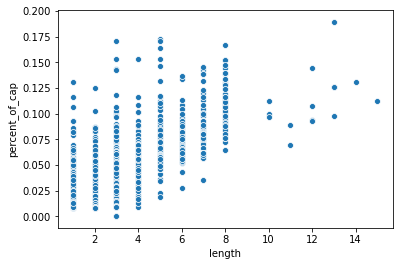

In [491]:
df = player_contracts.drop_duplicates(subset=['contract_id'])
sns.scatterplot(data=df, x='length', y='percent_of_cap', hue=)

<AxesSubplot:xlabel='contract_length', ylabel='percent_of_cap'>

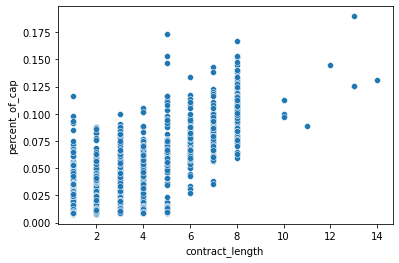

In [11]:
import seaborn as sns
df = player_contracts.drop_duplicates(subset=['contract_id'])
sns.scatterplot(data=df, x='contract_length', y='percent_of_cap')

In [493]:
player_contracts.to_csv("data/active_player_contracts.csv")